In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from wordcloud import WordCloud

In [7]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# Load the Financial PhraseBank dataset
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='latin-1') as file:
        for line in file:
            parts = line.strip().split('@')
            if len(parts) == 2:
                sentence, sentiment = parts
                data.append((sentence, sentiment))
    return pd.DataFrame(data, columns=['text', 'sentiment'])

# Assuming the dataset is downloaded and stored in 'Sentences_AllAgree.txt'
df = load_data('Sentences_AllAgree.txt')

In [9]:
# Preprocess the data
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['processed_text'] = df['text'].apply(preprocess_text)

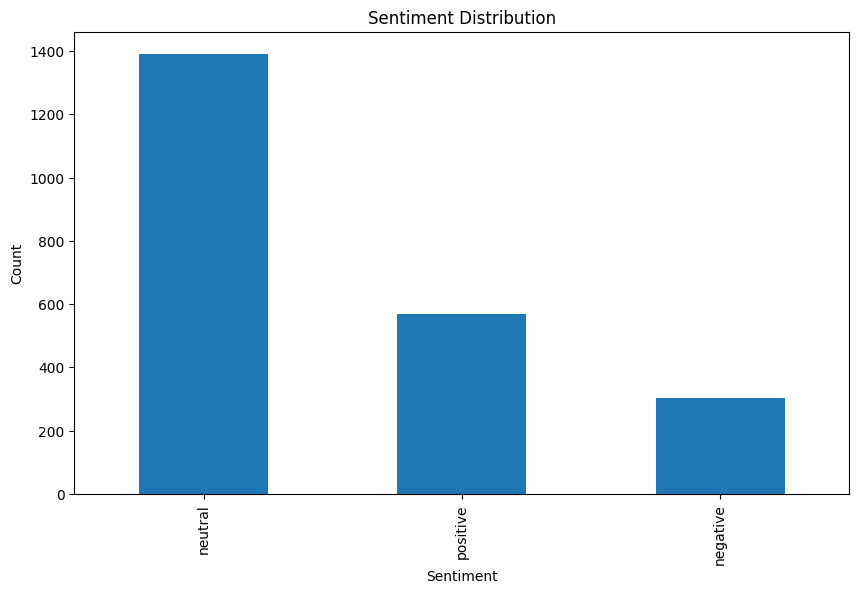

In [10]:
# Encode sentiments
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
df['sentiment_encoded'] = df['sentiment'].map(sentiment_mapping)

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

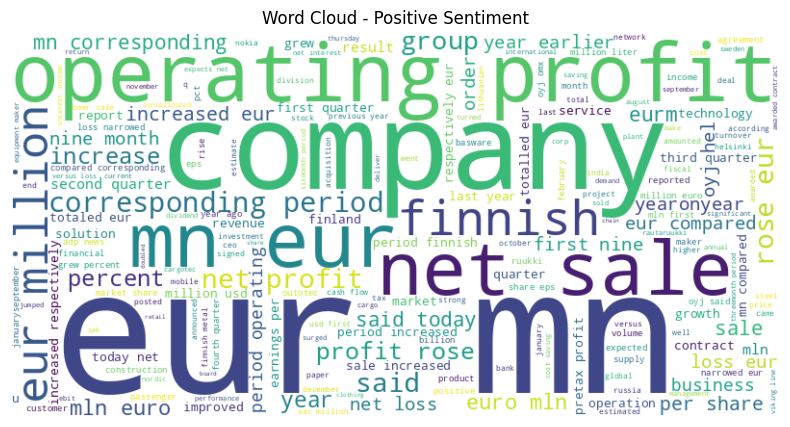

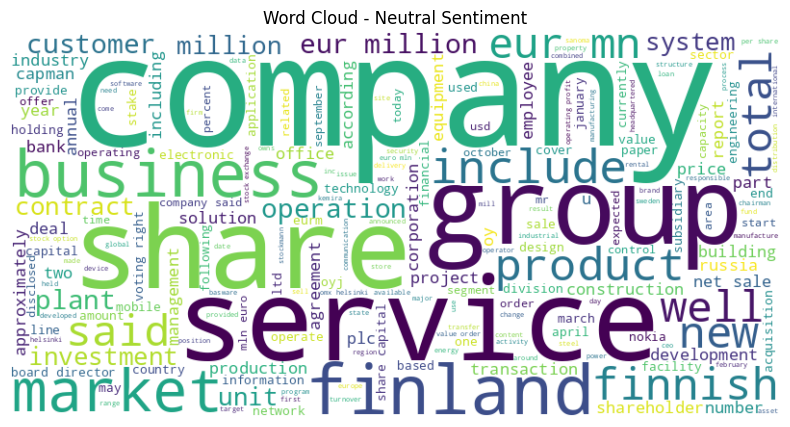

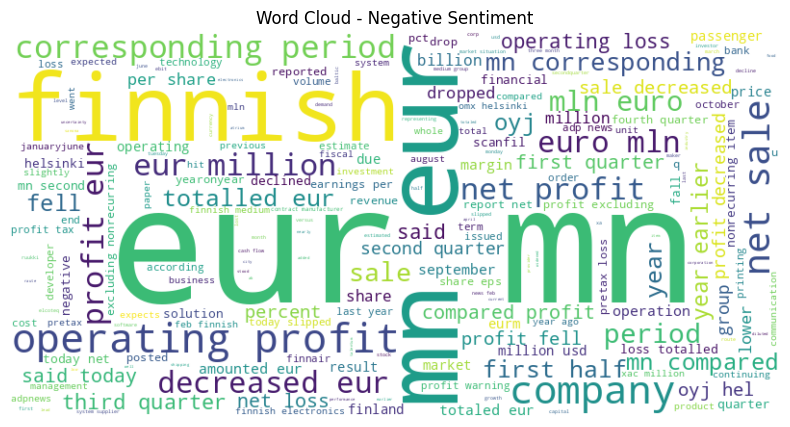

In [11]:
# Create word clouds for each sentiment
for sentiment in ['positive', 'neutral', 'negative']:
    text = ' '.join(df[df['sentiment'] == sentiment]['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {sentiment.capitalize()} Sentiment')
    plt.show()

In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['sentiment_encoded'], test_size=0.2, random_state=42)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer # Import TfidfVectorizer

from sklearn.svm import LinearSVC # Import LinearSVC



In [16]:
# TF-IDF Vectorization
print("Vectorizing text...")
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train LinearSVC model
print("Training LinearSVC model...")
model = LinearSVC(random_state=42)
model.fit(X_train_tfidf, y_train)

# Make predictions
print("Making predictions...")
predictions = model.predict(X_test_tfidf)

Vectorizing text...
Training LinearSVC model...
Making predictions...



Model Accuracy: 0.8477

Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.66      0.69        56
     neutral       0.87      0.97      0.92       276
    positive       0.84      0.66      0.74       121

    accuracy                           0.85       453
   macro avg       0.81      0.76      0.78       453
weighted avg       0.84      0.85      0.84       453



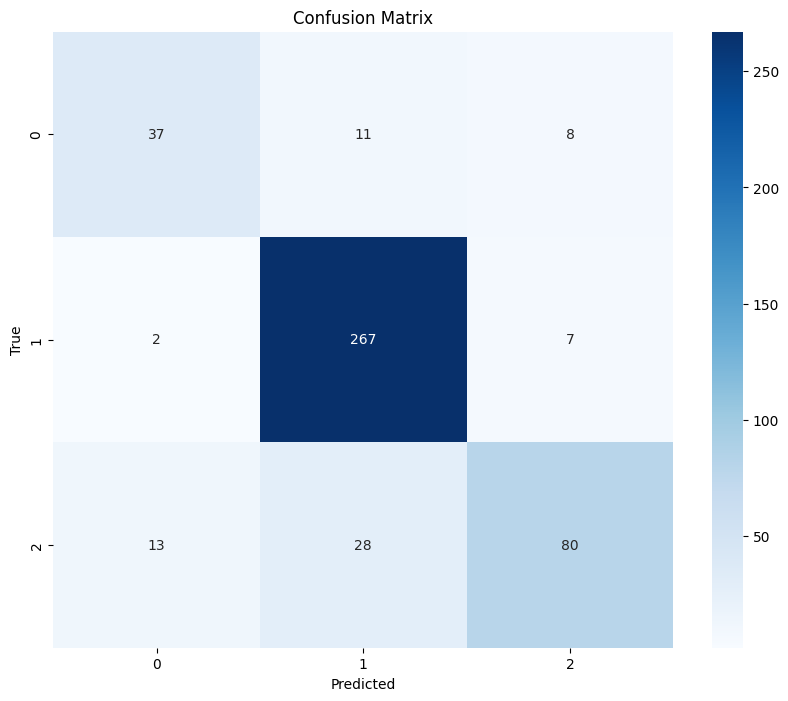

In [17]:
# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=['negative', 'neutral', 'positive']))

# Visualize confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
# Function to predict sentiment
def predict_sentiment(text):
    processed_text = preprocess_text(text)
    vectorized_text = tfidf.transform([processed_text])
    prediction = model.predict(vectorized_text)[0]
    probabilities = model.decision_function(vectorized_text)[0]
    sentiment_label = {0: 'negative', 1: 'neutral', 2: 'positive'}[prediction]
    return sentiment_label, probabilities


In [20]:
# Example usage
example_texts = [
    "The company reported strong earnings, exceeding analyst expectations.",
    "Despite market volatility, the stock remained stable throughout the quarter.",
    "Investors expressed concerns about the company's declining revenue and increasing debt."
]

print("\nExample Predictions:")
for text in example_texts:
    sentiment, probabilities = predict_sentiment(text)
    print(f"\nText: {text}")
    print(f"Predicted sentiment: {sentiment}")
    print(f"Decision function values: {probabilities}")



Example Predictions:

Text: The company reported strong earnings, exceeding analyst expectations.
Predicted sentiment: neutral
Decision function values: [-0.56109125 -0.20878002 -0.26994383]

Text: Despite market volatility, the stock remained stable throughout the quarter.
Predicted sentiment: neutral
Decision function values: [-0.9121814   0.45719634 -0.55298275]

Text: Investors expressed concerns about the company's declining revenue and increasing debt.
Predicted sentiment: neutral
Decision function values: [-0.34170707  0.09820685 -0.78873997]


In [21]:
# Save the model
import joblib
joblib.dump(model, 'financial_sentiment_model.joblib')
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
print("\nModel and vectorizer saved as 'financial_sentiment_model.joblib' and 'tfidf_vectorizer.joblib'")


Model and vectorizer saved as 'financial_sentiment_model.joblib' and 'tfidf_vectorizer.joblib'
